In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Rutter & Dekker et al 2024 analysis

### Prepare data

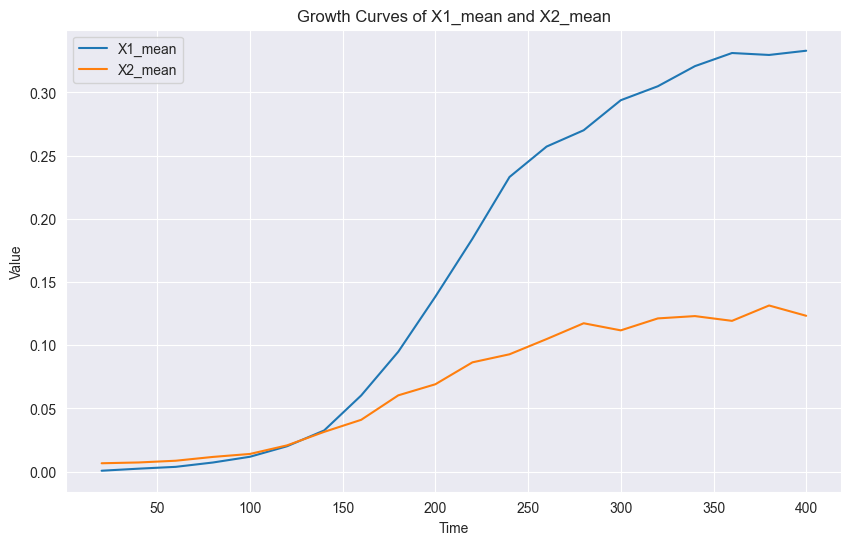

In [2]:
# read in the data
num_species = 2
num_timecourses = 4
data = pd.read_csv("PM3-EntA-coculture.csv")
data = data[(0 < data['time']) & (data['time'] <= 400)]  # Take only the first 400 minutes, excluding the first
times = data.iloc[:, 0].values

# Plot mean growth curves of each species
species_means = pd.DataFrame({
    "time": data.iloc[:,0],
    "X1_mean": data.iloc[:,[1,3,5,6]].mean(axis=1),
    "X2_mean": data.iloc[:,[2,4,6,8]].mean(axis=1)
})


# Plot growth curves
plt.figure(figsize=(10, 6))
plt.plot(species_means['time'], species_means['X1_mean'], label='X1_mean')
plt.plot(species_means['time'], species_means['X2_mean'], label='X2_mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Growth Curves of X1_mean and X2_mean')
plt.legend()
plt.show()

yobs = species_means.iloc[:,1:].to_numpy()

X, F = linearize_time_course_16S(yobs, times)


# Seperate and stack timecourses
yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
yobs_4 = data.iloc[:, (3*num_species+1):(4*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3, yobs_4])

# Replace negative values with 0
ryobs[ryobs < 0] = 0

#X = np.array([], dtype=np.double).reshape(0, num_species+1)
#F = np.array([], dtype=np.double).reshape(0, num_species)


#for timecourse_idx in range(num_timecourses):
#    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
#    X = np.vstack([X, Xs])
#    F = np.vstack([F, Fs])
    



### Perform Bayesian inference without shrinkage

X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
AdvancedSetSubtensor.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


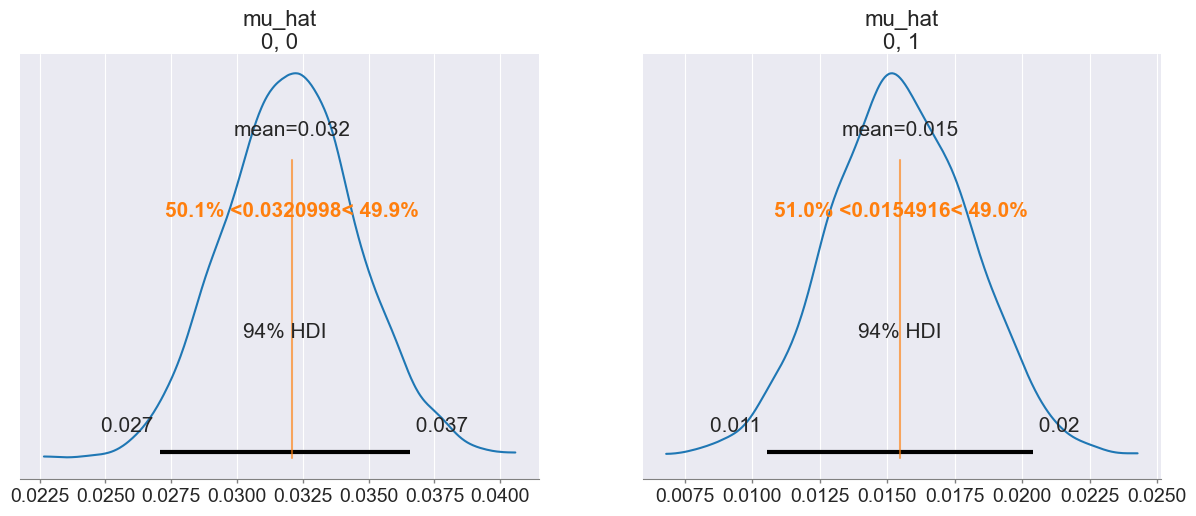

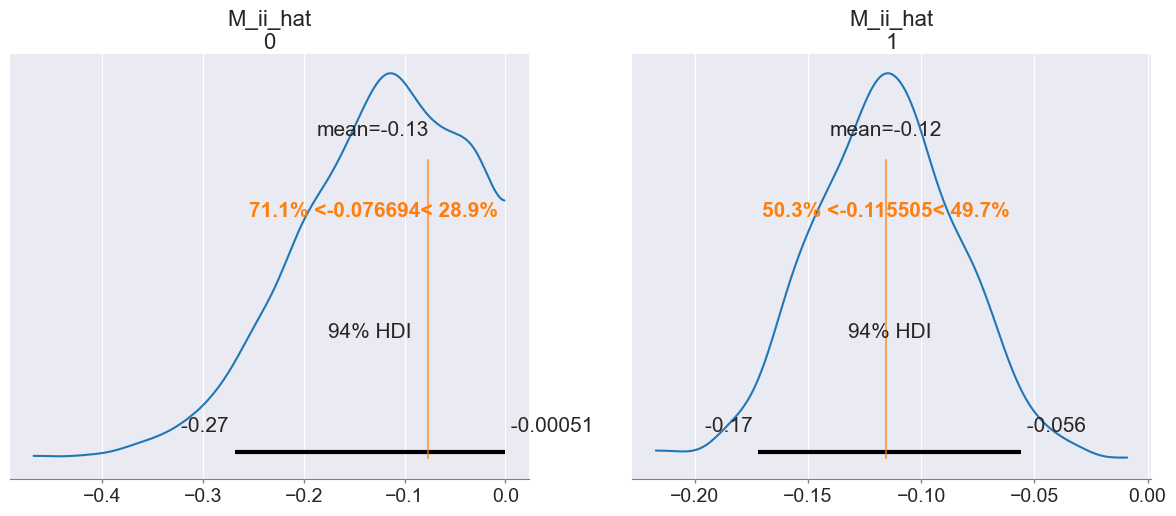

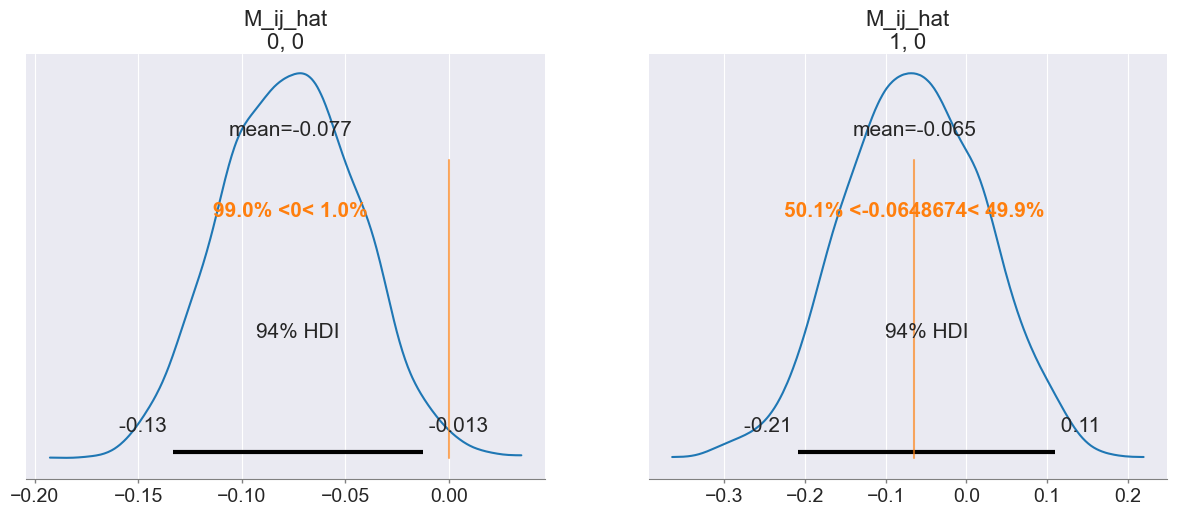

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.032  0.003   1.00
mu_hat[0, 1]    0.015  0.003   1.01
M_ii_hat[0]    -0.131  0.081   1.00
M_ii_hat[1]    -0.116  0.032   1.01
M_ij_hat[0, 0] -0.077  0.033   1.00
M_ij_hat[1, 0] -0.065  0.087   1.01
M_hat[0, 0]    -0.077  0.033   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.065  0.087   1.01
M_hat[1, 1]    -0.116  0.032   1.01
sigma[0]        0.006  0.001   1.00
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03209348, 0.01541384]), 'M': array([[-0.07658525, -0.06498282],
       [ 0.        , -0.11565129]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


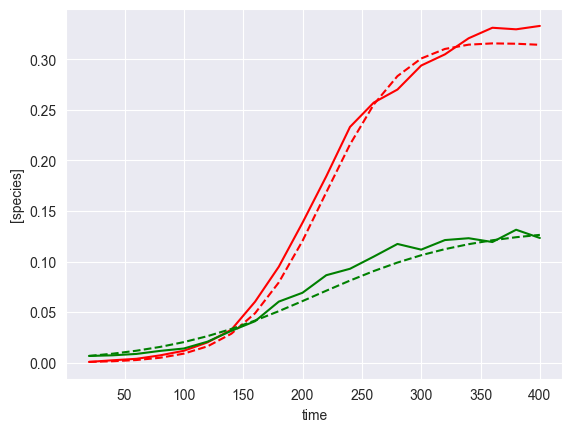

In [3]:
# Perform Bayesian inference without shrinkage

# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4


# Run inference using parameters as set above
inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


# To plot posterior distributions
inference.plot_posterior(idata)

# Print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)


## Perform Bayesian inference with shrinkage

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


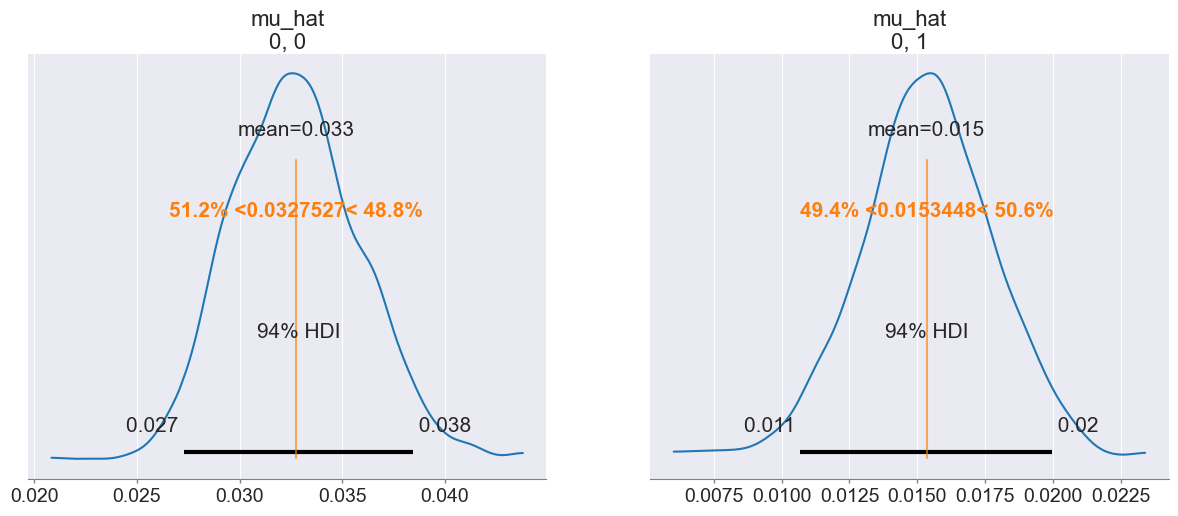

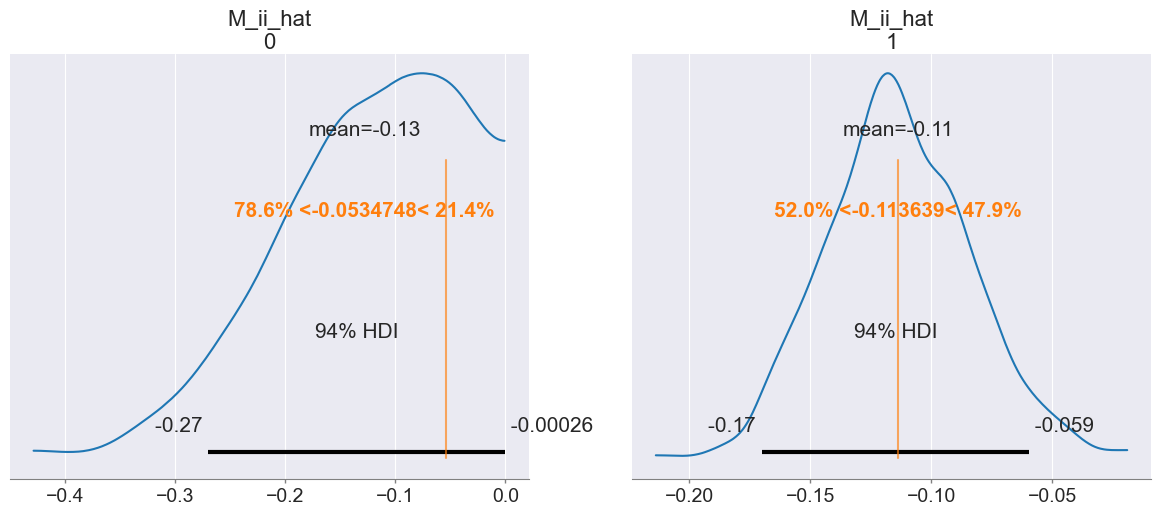

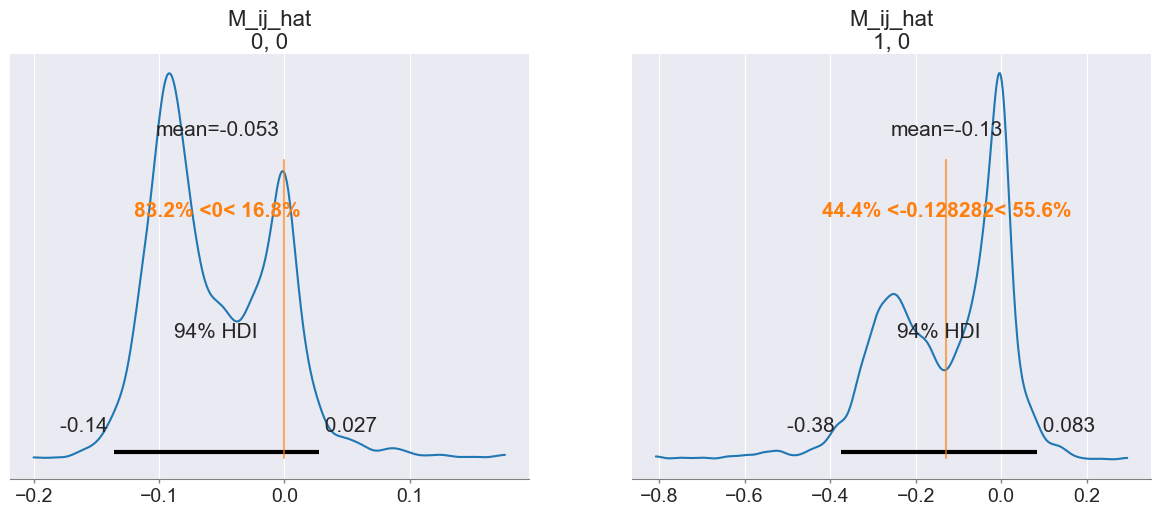

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.033  0.003   1.03
mu_hat[0, 1]    0.015  0.003   1.01
M_ii_hat[0]    -0.128  0.082   1.01
M_ii_hat[1]    -0.114  0.030   1.01
M_ij_hat[0, 0] -0.053  0.051   1.02
M_ij_hat[1, 0] -0.128  0.145   1.03
M_hat[0, 0]    -0.053  0.051   1.02
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.128  0.145   1.03
M_hat[1, 1]    -0.114  0.030   1.01
sigma[0]        0.006  0.001   1.00
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03262592, 0.01537789]), 'M': array([[-0.06542057, -0.08974062],
       [ 0.        , -0.11491935]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


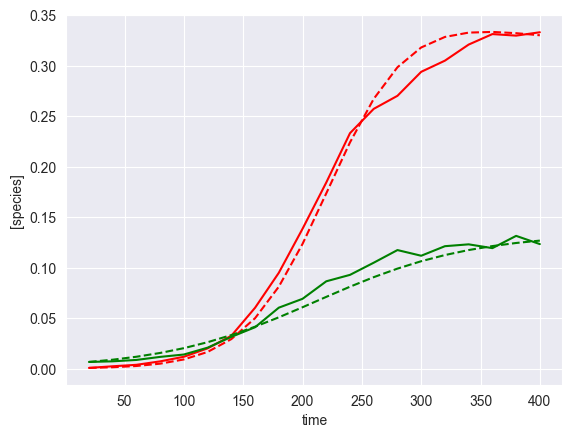

In [4]:
# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 1     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage()

# To plot posterior distributions
inference.plot_posterior(idata)

# Print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)